### import the packages

In [56]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


import scipy.stats as stats
import sklearn as sk
import statsmodels as sm
%matplotlib inline

plt.rcParams['figure.figsize'] = 6, 4
plt.rcParams['axes.grid'] = True

In [2]:
import pandas_profiling 

In [57]:
import statsmodels.formula.api as smf
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

### create UDFs

In [58]:
# Create Data audit Report for continuous variables

def continuous_var_summary(x):
    return pd.Series([x.count(), x.isnull().sum(), x.sum(), x.mean(), x.median(),  
                      x.std(), x.var(), x.min(), x.quantile(0.01), x.quantile(0.05),
                          x.quantile(0.10),x.quantile(0.25),x.quantile(0.50),x.quantile(0.75), 
                              x.quantile(0.90),x.quantile(0.95), x.quantile(0.99),x.max()], 
                  index = ['N', 'NMISS', 'SUM', 'MEAN','MEDIAN', 'STD', 'VAR', 'MIN', 'P1', 
                               'P5' ,'P10' ,'P25' ,'P50' ,'P75' ,'P90' ,'P95' ,'P99' ,'MAX'])

In [59]:
# Create Data audit Report for categorical variables

def categorical_var_summary(x):
    Mode = x.value_counts().sort_values(ascending = False)[0:1].reset_index()
    return pd.Series([x.count(), x.isnull().sum(), Mode.iloc[0, 0], Mode.iloc[0, 1], 
                          round(Mode.iloc[0, 1] * 100/x.count(), 2)], 
                  index = ['N', 'NMISS', 'MODE', 'FREQ', 'PERCENT'])

In [60]:
# Missing value imputation for categorical and continuous variables

def missing_imputation(x, stats = 'mean'):
    if (x.dtypes == 'float64') | (x.dtypes == 'int64'):
        x = x.fillna(x.mean()) if stats == 'mean' else x.fillna(x.median())
    else:
        x = x.fillna(x.mode())
    return x

In [61]:
# An utility function to create dummy variable

def create_dummies(df, colname):
    col_dummies = pd.get_dummies(df[colname], prefix = colname, drop_first = True)
    df = pd.concat([df, col_dummies], axis = 1)
    df.drop(colname, axis = 1, inplace = True )
    return df

### import data

In [62]:
data = pd.read_csv('C:/Users/yoosha/Downloads/Expander_data.csv')

### data inspection

In [63]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 296450 entries, 0 to 296449
Data columns (total 9 columns):
Timestamp                     296450 non-null object
Suction Pressure (psig)       296450 non-null float64
Suction Temperature (F)       296450 non-null float64
Total Flow (gpm)              296450 non-null float64
Speed (rpm)                   296450 non-null float64
By-pass Valve Position (%)    296450 non-null float64
Discharge Pressure (psig)     296450 non-null float64
Discharge Temperature (F)     296450 non-null float64
Run Status                    0 non-null float64
dtypes: float64(8), object(1)
memory usage: 20.4+ MB


In [13]:
# profiling using pandas profiling

report = pandas_profiling.ProfileReport(data)

In [14]:
# exporting the file as html

report.to_file(output_file = 'profilereport.html')

In [64]:
# seperate categorical and continuous variables

data_conti_vars = data.loc[:, (data.dtypes == 'float64') | (data.dtypes == 'int64')]
data_cat_vars = data.loc[:, (data.dtypes == 'object')]

In [65]:
# alternate of .describe() for continuous variables

data_conti_vars.apply(continuous_var_summary).T.round(1)

,N,NMISS,SUM,MEAN,MEDIAN,STD,VAR,MIN,P1,P5,P10,P25,P50,P75,P90,P95,P99,MAX
Suction Pressure (psig),296450.0,0.0,1.750660e+08,590.5,586.5,23.2,539.0,552.4,553.8,557.5,560.7,572.8,586.5,606.0,624.4,632.8,643.2,649.2
Suction Temperature (F),296450.0,0.0,-6.864742e+07,-231.6,-230.9,3.6,12.8,-238.6,-238.4,-237.8,-236.1,-234.2,-230.9,-229.6,-226.5,-224.8,-223.7,-223.4
Total Flow (gpm),296450.0,0.0,2.407150e+09,8119.9,8144.2,398.0,158443.4,7056.0,7130.4,7339.2,7505.2,7916.3,8144.2,8388.6,8573.1,8753.4,8930.4,8976.0
Speed (rpm),296450.0,0.0,8.761333e+08,2955.4,2961.8,54.2,2937.8,2835.8,2843.0,2873.8,2889.1,2906.3,2961.8,3000.9,3011.3,3014.8,3077.8,3090.4
By-pass Valve Position (%),296450.0,0.0,5.945800e+05,2.0,0.0,2.5,6.2,-0.2,0.0,0.0,0.0,0.0,0.0,4.0,6.0,6.0,8.0,8.0
Discharge Pressure (psig),296450.0,0.0,5.543351e+07,187.0,183.3,56.2,3159.0,70.0,80.1,94.9,126.0,143.5,183.3,223.6,265.4,300.6,312.2,324.4
Discharge Temperature (F),296450.0,0.0,-6.811381e+07,-229.8,-229.1,3.6,12.8,-236.8,-236.6,-236.0,-234.3,-232.4,-229.1,-227.8,-224.7,-223.0,-221.9,-221.6
Run Status,0.0,296450.0,0.000000e+00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [66]:
# alternate of .describe() for categorical variables

data_cat_vars.apply(categorical_var_summary).T

,N,NMISS,MODE,FREQ,PERCENT
Timestamp,296450,0,1/7/2020 11:48,4,0


## outlier treatment

In [67]:
data_conti_vars = data_conti_vars.apply(lambda x: x.clip(lower = x.dropna().quantile(0.01), upper = x.quantile(0.99)))

In [68]:
data_conti_vars.apply(continuous_var_summary).T.round(1)

,N,NMISS,SUM,MEAN,MEDIAN,STD,VAR,MIN,P1,P5,P10,P25,P50,P75,P90,P95,P99,MAX
Suction Pressure (psig),296450.0,0.0,1.750633e+08,590.5,586.5,23.2,536.8,553.8,553.8,557.5,560.7,572.8,586.5,606.0,624.4,632.8,643.2,643.2
Suction Temperature (F),296450.0,0.0,-6.864763e+07,-231.6,-230.9,3.6,12.7,-238.4,-238.4,-237.8,-236.1,-234.2,-230.9,-229.6,-226.5,-224.8,-223.7,-223.7
Total Flow (gpm),296450.0,0.0,2.407192e+09,8120.1,8144.2,396.6,157305.8,7130.4,7130.4,7339.2,7505.2,7916.3,8144.2,8388.6,8573.1,8753.4,8930.4,8930.4
Speed (rpm),296450.0,0.0,8.761257e+08,2955.4,2961.8,54.0,2913.6,2843.0,2843.0,2873.8,2889.1,2906.3,2961.8,3000.9,3011.3,3014.8,3077.8,3077.8
By-pass Valve Position (%),296450.0,0.0,5.945802e+05,2.0,0.0,2.5,6.2,0.0,0.0,0.0,0.0,0.0,0.0,4.0,6.0,6.0,8.0,8.0
Discharge Pressure (psig),296450.0,0.0,5.543319e+07,187.0,183.3,56.1,3144.2,80.1,80.1,94.9,126.0,143.5,183.3,223.6,265.4,300.6,312.2,312.2
Discharge Temperature (F),296450.0,0.0,-6.811402e+07,-229.8,-229.1,3.6,12.7,-236.6,-236.6,-236.0,-234.3,-232.4,-229.1,-227.8,-224.7,-223.0,-221.9,-221.9
Run Status,0.0,296450.0,0.000000e+00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Missing value treatment

In [69]:
data_conti_vars = data_conti_vars.apply(missing_imputation)

data_cat_vars = data_cat_vars.apply(missing_imputation)

In [70]:
data_conti_vars.apply(continuous_var_summary).T.round(1)

,N,NMISS,SUM,MEAN,MEDIAN,STD,VAR,MIN,P1,P5,P10,P25,P50,P75,P90,P95,P99,MAX
Suction Pressure (psig),296450.0,0.0,1.750633e+08,590.5,586.5,23.2,536.8,553.8,553.8,557.5,560.7,572.8,586.5,606.0,624.4,632.8,643.2,643.2
Suction Temperature (F),296450.0,0.0,-6.864763e+07,-231.6,-230.9,3.6,12.7,-238.4,-238.4,-237.8,-236.1,-234.2,-230.9,-229.6,-226.5,-224.8,-223.7,-223.7
Total Flow (gpm),296450.0,0.0,2.407192e+09,8120.1,8144.2,396.6,157305.8,7130.4,7130.4,7339.2,7505.2,7916.3,8144.2,8388.6,8573.1,8753.4,8930.4,8930.4
Speed (rpm),296450.0,0.0,8.761257e+08,2955.4,2961.8,54.0,2913.6,2843.0,2843.0,2873.8,2889.1,2906.3,2961.8,3000.9,3011.3,3014.8,3077.8,3077.8
By-pass Valve Position (%),296450.0,0.0,5.945802e+05,2.0,0.0,2.5,6.2,0.0,0.0,0.0,0.0,0.0,0.0,4.0,6.0,6.0,8.0,8.0
Discharge Pressure (psig),296450.0,0.0,5.543319e+07,187.0,183.3,56.1,3144.2,80.1,80.1,94.9,126.0,143.5,183.3,223.6,265.4,300.6,312.2,312.2
Discharge Temperature (F),296450.0,0.0,-6.811402e+07,-229.8,-229.1,3.6,12.7,-236.6,-236.6,-236.0,-234.3,-232.4,-229.1,-227.8,-224.7,-223.0,-221.9,-221.9
Run Status,0.0,296450.0,0.000000e+00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### final data for analysis

In [71]:
data_new = pd.concat([data_conti_vars, data_cat_vars], axis = 1)

In [72]:
data_new.head()

,Suction Pressure (psig),Suction Temperature (F),Total Flow (gpm),Speed (rpm),By-pass Valve Position (%),Discharge Pressure (psig),Discharge Temperature (F),Run Status,Timestamp
0,596.100853,-229.436683,7925.800487,2999.411045,6.0,226.044931,-227.614448,NaN,1/4/2020 21:20
1,596.838217,-230.453708,8085.917724,2989.706617,6.0,217.150974,-228.668636,NaN,1/4/2020 21:20
2,596.468895,-229.545356,7902.175243,3006.331679,6.0,226.054086,-227.755324,NaN,1/4/2020 21:20
3,603.568271,-230.309438,7991.808959,3010.487486,6.0,226.016182,-228.489113,NaN,1/4/2020 21:20
4,595.407372,-229.767969,7871.560747,2986.665518,6.0,227.769383,-227.971795,NaN,1/4/2020 21:21


### Assumptions check

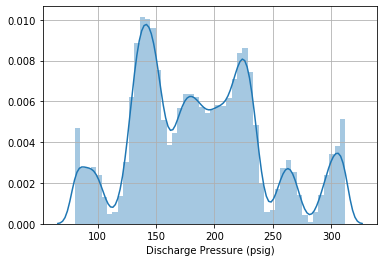

In [73]:
# Very first assumtion is that all the variables should be normally distributed, however that can't be possible
# However we have to be atleast strict about the dependant Y variable

# Distribution of variables
sns.distplot(data_new['Discharge Pressure (psig)'])
plt.show()
# this distribution is highly skewed


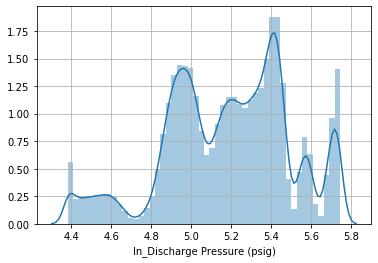

In [74]:
# apply log transformation: log is recalling the data and making the distribution normal

data_new['ln_Discharge Pressure (psig)'] = np.log(data_new['Discharge Pressure (psig)'])

# Distribution of variables

sns.distplot(data_new['ln_Discharge Pressure (psig)'])
plt.show()

In [75]:
# Linearity: correlation matrix (ranges from 1 to -1)

corrm = data_new.corr()

#corrm.to_csv('corrm.csv')

corrm

,Suction Pressure (psig),Suction Temperature (F),Total Flow (gpm),Speed (rpm),By-pass Valve Position (%),Discharge Pressure (psig),Discharge Temperature (F),Run Status,ln_Discharge Pressure (psig)
Suction Pressure (psig),1.000000,0.863008,-0.873614,-0.370362,0.089923,0.905570,0.863004,NaN,0.872692
Suction Temperature (F),0.863008,1.000000,-0.939372,-0.500414,0.348880,0.960169,0.999993,NaN,0.949232
Total Flow (gpm),-0.873614,-0.939372,1.000000,0.484509,-0.275904,-0.973883,-0.939365,NaN,-0.956042
Speed (rpm),-0.370362,-0.500414,0.484509,1.000000,0.174440,-0.435291,-0.500415,NaN,-0.366548
By-pass Valve Position (%),0.089923,0.348880,-0.275904,0.174440,1.000000,0.399752,0.348876,NaN,0.410360
Discharge Pressure (psig),0.905570,0.960169,-0.973883,-0.435291,0.399752,1.000000,0.960162,NaN,0.981168
Discharge Temperature (F),0.863004,0.999993,-0.939365,-0.500415,0.348876,0.960162,1.000000,NaN,0.949225
Run Status,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ln_Discharge Pressure (psig),0.872692,0.949232,-0.956042,-0.366548,0.410360,0.981168,0.949225,NaN,1.000000


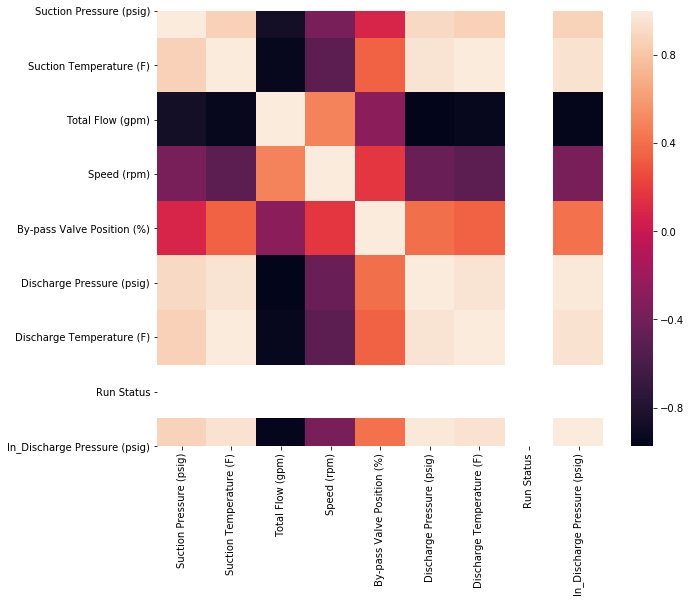

In [76]:
# visualize correlation matrix in Seaborn using a heatmap

plt.figure(figsize = (10, 8))
sns.heatmap(data_new.corr())

In [77]:
# dropping variables which are insignificant and have null values in the data

data_new.drop(['Timestamp' , 'Run Status'], axis = 1, inplace = True)

In [78]:
# no of variables and obervations in the final data to be used for modelling

data_new.shape

(296450, 8)

In [79]:
data_new.head()

,Suction Pressure (psig),Suction Temperature (F),Total Flow (gpm),Speed (rpm),By-pass Valve Position (%),Discharge Pressure (psig),Discharge Temperature (F),ln_Discharge Pressure (psig)
0,596.100853,-229.436683,7925.800487,2999.411045,6.0,226.044931,-227.614448,5.420734
1,596.838217,-230.453708,8085.917724,2989.706617,6.0,217.150974,-228.668636,5.380593
2,596.468895,-229.545356,7902.175243,3006.331679,6.0,226.054086,-227.755324,5.420774
3,603.568271,-230.309438,7991.808959,3010.487486,6.0,226.016182,-228.489113,5.420607
4,595.407372,-229.767969,7871.560747,2986.665518,6.0,227.769383,-227.971795,5.428334


In [80]:
# Renaming the columns of the data

data_new.rename(columns={'ln_Discharge Pressure (psig)' : 'ln_Discharge_Pressure' ,'Suction Pressure (psig)' :'Suction_Pressure'
                         ,'Suction Temperature (F)' : 'Suction_Temperature' , 'Total Flow (gpm)' : 'Total_Flow'
                        , 'Speed (rpm)' : 'Speed', 'By-pass Valve Position (%)' : 'By_pass_Valve_Position' 
                         , 'Discharge Temperature (F)' : 'Discharge_Temperature'} , inplace = True)

In [81]:
data_new.head()

,Suction_Pressure,Suction_Temperature,Total_Flow,Speed,By_pass_Valve_Position,Discharge Pressure (psig),Discharge_Temperature,ln_Discharge_Pressure
0,596.100853,-229.436683,7925.800487,2999.411045,6.0,226.044931,-227.614448,5.420734
1,596.838217,-230.453708,8085.917724,2989.706617,6.0,217.150974,-228.668636,5.380593
2,596.468895,-229.545356,7902.175243,3006.331679,6.0,226.054086,-227.755324,5.420774
3,603.568271,-230.309438,7991.808959,3010.487486,6.0,226.016182,-228.489113,5.420607
4,595.407372,-229.767969,7871.560747,2986.665518,6.0,227.769383,-227.971795,5.428334


### spliting the data for model building

In [82]:
# splitting the data: separate out the feature/input/independant columns and dependant variable

feature_columns = data_new.columns.difference(['ln_Discharge_Pressure', 'Discharge Pressure (psig)'])

In [83]:
# method 1: divide the data into training and testing and separate out X and Y variables
# this will be used in sklearn related functions if required

train_X, test_X, train_y, test_y = train_test_split(data_new[feature_columns], 
                                            data_new['ln_Discharge_Pressure'], test_size = 0.3, random_state = 12345)

In [84]:
# method 2: divide the data into training and testing

train, test = train_test_split(data_new, test_size = 0.3, random_state = 12345)

In [85]:
# verify the number of observations in training and testing after split

print('No of obs in training: ', len(train), ' | ', 'No of obs in testing: ', len(test))

No of obs in training:  207515  |  No of obs in testing:  88935


# Building a Regression Model

In [86]:
# Step 1: defining Y, X and building a ols model

model_param = '''ln_Discharge_Pressure ~ Suction_Pressure + Suction_Temperature + Total_Flow 
                                         + Speed + By_pass_Valve_Position + Discharge_Temperature'''

In [87]:
# Step 2: fitting the model

lm1 = smf.ols(model_param , train).fit()

In [88]:
# Step 3: getting the output summary of the model

print(lm1.summary())

                              OLS Regression Results                             
Dep. Variable:     ln_Discharge_Pressure   R-squared:                       0.963
Model:                               OLS   Adj. R-squared:                  0.963
Method:                    Least Squares   F-statistic:                 8.948e+05
Date:                   Sun, 02 Feb 2020   Prob (F-statistic):               0.00
Time:                           09:38:04   Log-Likelihood:             2.8730e+05
No. Observations:                 207515   AIC:                        -5.746e+05
Df Residuals:                     207508   BIC:                        -5.745e+05
Df Model:                              6                                         
Covariance Type:               nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------

In [89]:
# Step 4: predicting the sales on the training data

train['pred_Discharge_Pressure'] = np.exp(lm1.predict(train))

C:\Users\yoosha\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [90]:
# Step 5: predicting the sales on the testing/validation data

test['pred_Discharge_Pressure'] = np.exp(lm1.predict(test))

C:\Users\yoosha\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [91]:
# Step 6: accuracy metrics (a. MAPE: Mean Absolute Percentage Error)

MAPE_train = np.mean(np.abs(train['Discharge Pressure (psig)'] - train['pred_Discharge_Pressure'])/train['Discharge Pressure (psig)'])
MAPE_test = np.mean(np.abs(test['Discharge Pressure (psig)'] - test['pred_Discharge_Pressure'])/test['Discharge Pressure (psig)'])

# print the values of MAPE for train and test
print('MAPE of training data: ', MAPE_train,  ' | ', 'MAPE of testing data: ', MAPE_test)

MAPE of training data:  0.04743196364844061  |  MAPE of testing data:  0.04741837766543699


In [92]:
# Step 7: accuracy metrics (d. Decile Analysis: for validation of models - Business validation)

# create the 10 groups in the data
train['Deciles'] = pd.qcut(train['pred_Discharge_Pressure'], 10, labels = False)
test['Deciles'] = pd.qcut(test['pred_Discharge_Pressure'], 10, labels = False)

# Decile Analysis for train data
Predicted_avg = train[['Deciles', 'pred_Discharge_Pressure']].groupby(train.Deciles).mean().sort_index(ascending = False)['pred_Discharge_Pressure']
Actual_avg = train[['Deciles', 'Discharge Pressure (psig)']].groupby(train.Deciles).mean().sort_index(ascending = False)['Discharge Pressure (psig)']
Decile_analysis_train = pd.concat([Predicted_avg, Actual_avg], axis = 1).reset_index()

# Decile Analysis for test data
Predicted_avg = test[['Deciles', 'pred_Discharge_Pressure']].groupby(test.Deciles).mean().sort_index(ascending = False)['pred_Discharge_Pressure']
Actual_avg = test[['Deciles', 'Discharge Pressure (psig)']].groupby(test.Deciles).mean().sort_index(ascending = False)['Discharge Pressure (psig)']
Decile_analysis_test = pd.concat([Predicted_avg, Actual_avg], axis = 1).reset_index()

# Displaying the data into the file

# Decile_analysis_train.to_csv('Decile_analysis_train.csv')
# Decile_analysis_test.to_csv('Decile_analysis_test.csv')

C:\Users\yoosha\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
C:\Users\yoosha\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [93]:
Decile_analysis_train

,Deciles,pred_Discharge_Pressure,Discharge Pressure (psig)
0,9,324.619616,294.997016
1,8,240.749782,243.316864
2,7,214.560404,223.723362
3,6,199.650010,209.467052
4,5,184.613966,191.894655
5,4,171.171659,175.418789
6,3,154.546738,156.012744
7,2,144.231988,143.034010
8,1,132.971966,133.678573
9,0,104.940959,98.314909


In [94]:
Decile_analysis_test

,Deciles,pred_Discharge_Pressure,Discharge Pressure (psig)
0,9,325.006398,295.206061
1,8,240.967757,243.570938
2,7,214.413160,223.588048
3,6,199.623902,209.423281
4,5,184.708608,191.938840
5,4,171.057300,175.336412
6,3,154.382939,155.837041
7,2,144.251680,143.012210
8,1,133.193819,133.711614
9,0,104.989386,98.373700


####  VIF (Variance Inflation Factor): Check the multicollinieirity for all the variables in the model

In [95]:
# High VIF of the variable means information in that variable has already been explained by 
# other X variables present in the model

# importing the packages for vif
from statsmodels.stats.outliers_influence import variance_inflation_factor
from patsy import dmatrices

# separating the Y and X variables
y, X = dmatrices(model_param, train, return_type = 'dataframe')

# For each X, calculating VIF and save in a dataframe
vif = pd.DataFrame()
vif['Features'] = X.columns
vif['VIF Factor'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# displaying the output
vif.round(1)

,Features,VIF Factor
0,Intercept,68251.1
1,Suction_Pressure,6.7
2,Suction_Temperature,73641.8
3,Total_Flow,9.9
4,Speed,2.0
5,By_pass_Valve_Position,2.1
6,Discharge_Temperature,73634.9


Since two variables i.e. Suction_Pressure and Discharge_Temperature shows high VIF value these variables shows high collinearity.

### feature selection based on importance using F - Regression

In [96]:
# Feature Selection based on importance
from sklearn.feature_selection import f_regression
features = train_X
target = train_y
F_values, p_values  = f_regression(features, target )

In [97]:
import itertools
f_reg_results = [(i, v, z) for i, v, z in itertools.zip_longest(features.columns, F_values,  ['%.3f' % p for p in p_values])]
f_reg_results=pd.DataFrame(f_reg_results, columns=['Variable','F_Value', 'P_Value'])
f_reg_results

,Variable,F_Value,P_Value
0,By_pass_Valve_Position,4.209281e+04,0.000
1,Discharge_Temperature,1.882952e+06,0.000
2,Speed,3.182517e+04,0.000
3,Suction_Pressure,6.617709e+05,0.000
4,Suction_Temperature,1.883263e+06,0.000
5,Total_Flow,2.201959e+06,0.000


Since all the p - values are zero, all the variables are siginificant in the regression equation.

#### Execute the model on training and testing samples

In [98]:
# Step 1: predicting the sales on the training data
train['pred_Discharge_Pressure'] = np.exp(lm1.predict(train))

C:\Users\yoosha\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [99]:
# Step 2: predicting the sales on the testing/validation data
test['pred_Discharge_Pressure'] = np.exp(lm1.predict(test))

C:\Users\yoosha\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


#### model validation for prediction

In [100]:
# Step 3: accuracy metrics (b. RMSE: Root Mean Squared Error)
RMSE_train = np.sqrt(mean_squared_error(train['Discharge Pressure (psig)'] ,train.pred_Discharge_Pressure).round(3))
RMSE_test = np.sqrt(mean_squared_error(test['Discharge Pressure (psig)'] ,test.pred_Discharge_Pressure).round(3))

# printing the values of RMSE for train and test
print('RMSE of training data: ', RMSE_train,  ' | ', 'RMSE of testing data: ', RMSE_test)

RMSE of training data:  12.714873180649503  |  RMSE of testing data:  12.75049018665557


In [101]:
# Step 4: accuracy metrics (c. Correlation)
Corr_train = stats.stats.pearsonr(train['Discharge Pressure (psig)'] , train.pred_Discharge_Pressure)
Corr_test = stats.stats.pearsonr(train['Discharge Pressure (psig)'] , train.pred_Discharge_Pressure)

# printing the values of Correlation for train and test
print('Correlation of training data: ', Corr_train,  ' | ', 'Correlation of testing data: ', Corr_test)

Correlation of training data:  (0.9790945929255052, 0.0)  |  Correlation of testing data:  (0.9790945929255052, 0.0)


#### Validate the poor model performance due of LM assumptions

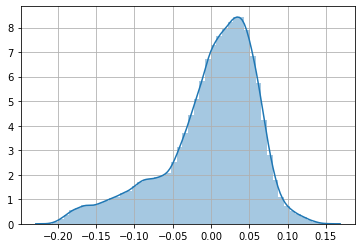

In [102]:
# assumption: Normality of the residuals/error (using distribution plot)
sns.distplot(lm1.resid)
plt.show()

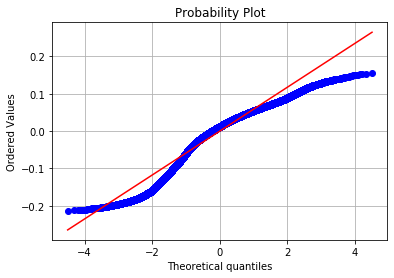

In [103]:
# assumption: Normality of the residuals/errors (using Q-Q plot)
from scipy import stats
import pylab

stats.probplot(lm1.resid, dist = 'norm', plot = pylab)
pylab.show()

# If errors are normally and randomly distributed, they would be following a straight line pattern
# Q-Q plot shows if the residuals are plotted along the line

In [104]:
# assumption: mean of residuals/errors is zero

print(lm1.resid.mean())

8.265946537465544e-14


In [105]:
# assumption: residuals/errors of the model should not be correlated with dependant (Y) variable

print(stats.stats.pearsonr(lm1.resid, train.ln_Discharge_Pressure))

(0.19290322631263035, 0.0)


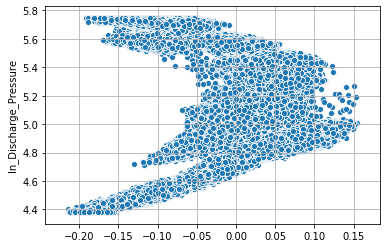

In [106]:
# assumption: homoscedasticity of residuals/errors

sns.scatterplot(lm1.resid, train.ln_Discharge_Pressure)
plt.show()

# Linear Regression Model

In [107]:
clf_linear= LinearRegression()
clf_linear.fit(train_X, train_y)
y_pred_linear=clf_linear.predict(test_X)
acc_linear=round( clf_linear.score(test_X,test_y) * 100, 2)
print ('score:'+str(acc_linear) + ' percent')

score:96.28 percent


# Random Forest

In [108]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor

In [109]:
clf_rf= RandomForestRegressor(n_estimators=100)
clf_rf.fit(train_X, train_y)
y_pred_rf= clf_rf.predict(test_X)
acc_rf = round( clf_rf.score(test_X,test_y) * 100, 2)
print (str(acc_rf) + ' percent')

99.95 percent


## Building Decision Tree Model

In [110]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
from sklearn import metrics

In [111]:
# initalizing and building the model
clf_tree = DecisionTreeRegressor( max_depth = 6 )
clf_tree = clf_tree.fit( train_X, train_y )
y_pred_dt= clf_dt.predict(test_X)
acc_dt = round( clf_dt.score(test_X, test_y) * 100, 2)
print (str(acc_dt) + ' percent')

99.9 percent


In [112]:
# predicting the values
train_y_predict = clf_tree.predict(train_X)
test_y_predict = clf_tree.predict(test_X)

In [113]:
# getting the accuracy score for the training and testing
print('Train Accuracy: ', metrics.mean_squared_error(train_y, train_y_predict).round(4))
print('Test Accuracy: ', metrics.mean_squared_error(test_y, test_y_predict).round(4))

Train Accuracy:  0.0008
Test Accuracy:  0.0008


### Decision Trees shows quite low mse for Training and Testing data , therefore the model is quite accurate with minimum errors.

# Comparing Models

In [114]:
models = pd.DataFrame({
    'Model': ['Linear Regression','Decision Tree', 'Random Forest'],
    
    'Score': [acc_linear,acc_dt,acc_rf]
    })

models.sort_values(by='Score', ascending=False)

,Model,Score
2,Random Forest,99.95
1,Decision Tree,99.90
0,Linear Regression,96.28


# INFERENCE

# Since all the models are showing a pretty good score, we can opt any of the model for Data Science and visualization.